# Model import using the Petab format

In [1]:
import pypesto
import amici
import petab

import os
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Download benchmark models - Note: 200MB :(
!git clone --depth 1 https://github.com/LoosC/Benchmark-Models.git tmp/benchmark-models || (cd tmp/benchmark-models && git pull)

fatal: destination path 'tmp/benchmark-models' already exists and is not an empty directory.
Already up to date.


## Manage PEtab model

In [2]:
folder_base = "tmp/benchmark-models/hackathon_contributions_new_data_format/"
model_name = "Zheng_PNAS2012"
model_name = "Boehm_JProteomeRes2014"
yaml_config = os.path.join(folder_base, model_name, model_name + '.yaml')

petab_problem = petab.Problem.from_yaml(yaml_config)

petab_problem.get_optimization_to_simulation_parameter_mapping()


[({},
  {'Epo_degradation_BaF3': 'Epo_degradation_BaF3',
   'k_exp_hetero': 'k_exp_hetero',
   'k_exp_homo': 'k_exp_homo',
   'k_imp_hetero': 'k_imp_hetero',
   'k_imp_homo': 'k_imp_homo',
   'k_phos': 'k_phos',
   'ratio': 0.693,
   'noiseParameter1_pSTAT5A_rel': 'sd_pSTAT5A_rel',
   'noiseParameter1_pSTAT5B_rel': 'sd_pSTAT5B_rel',
   'noiseParameter1_rSTAT5A_rel': 'sd_rSTAT5A_rel',
   'specC17': 0.107})]

## Import model to AMICI

In [3]:
importer = pypesto.PetabImporter(petab_problem)

model = importer.create_model()
print("Model parameters:", list(model.getParameterIds()), '\n')
print("Model const parameters:", list(model.getFixedParameterIds()), '\n')
print("Model outputs:   ", list(model.getObservableIds()), '\n')
print("Model states:    ", list(model.getStateIds()), '\n')

Model parameters: ['Epo_degradation_BaF3', 'k_exp_hetero', 'k_exp_homo', 'k_imp_hetero', 'k_imp_homo', 'k_phos', 'ratio', 'noiseParameter1_pSTAT5A_rel', 'noiseParameter1_pSTAT5B_rel', 'noiseParameter1_rSTAT5A_rel', 'specC17'] 

Model const parameters: [] 

Model outputs:    ['observable_pSTAT5A_rel', 'observable_pSTAT5B_rel', 'observable_rSTAT5A_rel'] 

Model states:     ['STAT5A', 'STAT5B', 'pApB', 'pApA', 'pBpB', 'nucpApA', 'nucpApB', 'nucpBpB'] 



## Create objective function

In [4]:
obj = importer.create_objective()

#print(amici.getDataObservablesAsDataFrame(obj.amici_model, edatas))
#print(edatas[0].fixedParametersPreequilibration)
#print(obj.dim, obj.x_names, len(obj.x_ids), obj.opt_to_sim_par_mapping)
#print(edatas[0].fixedParametersPreequilibration, edatas[0].fixedParameters)

print("Nominal parameter values:\n", petab_problem.x_nominal)
print("Scaled nominal parameter values:\n", petab_problem.x_nominal)

obj(petab_problem.x_nominal_scaled)

Nominal parameter values:
 [0.02698251403302893, 1.0006797385150757e-05, 0.006170228086381237, 0.016367918446800373, 97749.37940247158, 15766.5070195731, 0.693, 3.852611978446772, 6.591478186734192, 3.152712756485266, 0.107]
Scaled nominal parameter values:
 [0.02698251403302893, 1.0006797385150757e-05, 0.006170228086381237, 0.016367918446800373, 97749.37940247158, 15766.5070195731, 0.693, 3.852611978446772, 6.591478186734192, 3.152712756485266, 0.107]


138.22199706661652

## Run optimization

In [5]:
optimizer = pypesto.ScipyOptimizer()

problem = importer.create_problem(obj)

engine = pypesto.SingleCoreEngine()
# engine = pypesto.MultiProcessEngine()

# do the optimization
result = pypesto.minimize(problem=problem, optimizer=optimizer,
                          n_starts=5, engine=engine)

[Warning] AMICI:mex:CVODES:CVode:ERR_FAILURE: AMICI ERROR: in module CVODES in function CVode : At t = 96.2103 and h = 3.22567e-05, the error test failed repeatedly or with |h| = hmin. 
[Warning] AMICI:mex:simulation: AMICI forward simulation failed at t = 96.210277:
AMICI failed to integrate the forward problem

[Warning] AMICI:mex:CVODES:CVode:ERR_FAILURE: AMICI ERROR: in module CVODES in function CVode : At t = 96.2103 and h = 3.22567e-05, the error test failed repeatedly or with |h| = hmin. 
[Warning] AMICI:mex:simulation: AMICI forward simulation failed at t = 96.210277:
AMICI failed to integrate the forward problem

[Warning] AMICI:mex:CVODES:CVode:ERR_FAILURE: AMICI ERROR: in module CVODES in function CVode : At t = 96.2103 and h = 3.22567e-05, the error test failed repeatedly or with |h| = hmin. 
[Warning] AMICI:mex:simulation: AMICI forward simulation failed at t = 96.210277:
AMICI failed to integrate the forward problem

[Warning] AMICI:mex:CVODES:CVode:ERR_FAILURE: AMICI ERR

## Visualize

[149.58782897689036, 193.1038975386742, 193.10700772071417, 249.74599738261077, 249.7459974433296]


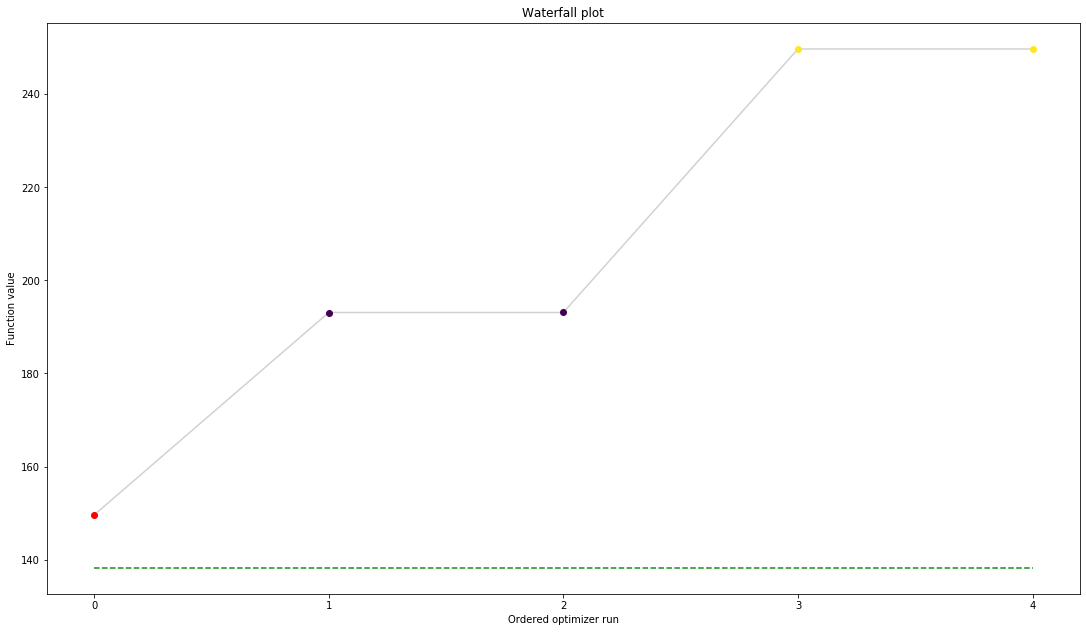

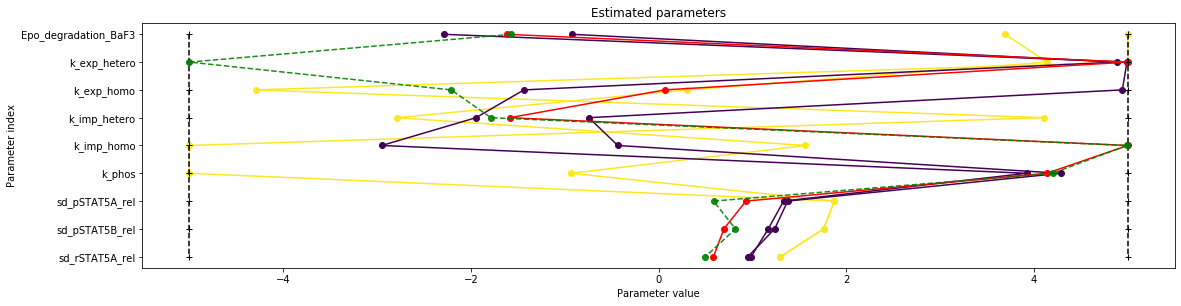

In [6]:
import pypesto.visualize

ref = pypesto.visualize.create_references(x=petab_problem.x_nominal_scaled, fval=obj(petab_problem.x_nominal_scaled))

pypesto.visualize.waterfall(result, reference=ref, scale_y='lin')
pypesto.visualize.parameters(result, reference=ref)

print(result.optimize_result.get_for_key('fval'))

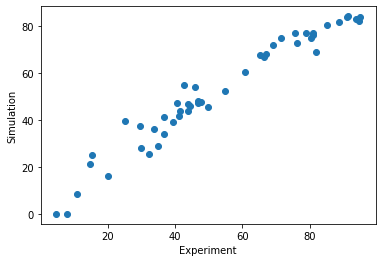

In [7]:
rdatas = obj(result.optimize_result.get_for_key('x')[0], return_dict=True)['rdatas']
df = importer.rdatas_to_measurement_df(rdatas)

plt.xlabel("Experiment")
plt.ylabel("Simulation")

# note: here we still assume that both files have the same order
plt.scatter(petab_problem.measurement_df['measurement'], df['measurement'])

# print(df)